# Telco Churn Classification Project

### By : Daniel Northcutt
### 11/29/21

# Project Overview

(To be completed)

# Project Goal

(To be completed)

# EXECUTIVE SUMMARY

(To be completed)

# Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
from graphviz import Graph

import acquire
import prepare
import user_defined_functions

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Acquire Data

In [2]:
telco = acquire.get_telco_data()
df = telco
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


# Acquire Takeaways

- (To be completed)



# ----------------------------------------------------------------

# Prepare Data

In [36]:
#preliminary clean delco:
def prep_telco(df):

    df = df.drop_duplicates()  #Drop duplicates
    
    #11 values are blank strings for total charges representing 11 customers at 0 tenure
    df['total_charges'] = df['total_charges'].str.strip() #eliminate white space
    df['total_charges'] = df['total_charges'].replace('', 0) #replace empty values as 0
    df['total_charges'] = df['total_charges'].astype('float64')

    #15 columns encoded to '0' = No, '1'= Yes
    #contract type MtM = 0, 1year = 1, 2year =2
    #concated manual billing = 0 , automatic billing = 1
    df['gender'] = df.gender.replace({'Female': 0, 'Male': 1})
    df['partner'] = df.partner.replace({'Yes': 1, 'No': 0})
    df['dependents'] = df.dependents.replace({'Yes': 1, 'No': 0})
    df['phone_service'] = df.phone_service.replace({'Yes': 1, 'No': 0})
    df['churn'] = df.churn.replace({'Yes': 1, 'No': 0})
    df['multiple_lines'] = df.multiple_lines.replace({'No': 0, "Yes": 1, "No phone service": 0})
    df['online_secuirty'] = df.online_security.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['online_backup'] = df.online_backup.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['device_protection'] = df.device_protection.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['tech_support'] = df.tech_support.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['streaming_tv'] = df.streaming_tv.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['streaming_movies'] = df.streaming_movies.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['paperless_billing'] = df.paperless_billing.replace({'Yes': 1, 'No': 0})
    #df['contract_type'] = df.contract_type.replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
    df['payment_type'] = df.payment_type.replace({'Mailed check': 0, 'Credit card (automatic)': 1, 
                                               'Bank transfer (automatic)': 1,  'Electronic check': 0})


    # creating dummy values for payment, internet, & contract (*important values*)
    dummy_df = pd.get_dummies(df[['payment_type',"internet_service_type","contract_type"]])
    df = pd.concat([df, dummy_df], axis=1)

    #Rename columns
    columns_to_rename = {'contract_type': 'contract',
                    'internet_service_type': 'internet',
                    'gender': 'is_male',
                     'payment_type_id': 'payment_id',
                     'contract_type_id': 'contract_type',
                     'internet_service_type_DSL': 'DSL',
                     'internet_service_type_Fiber optic': 'fiber_optic',
                     'internet_service_type_None': 'no_internet',
                     'contract_type_Month-to-month': 'month_to_month',
                     'contract_type_One year': 'one_year_contract',
                     'contract_type_Two year': 'two_year_contract'}
    df = df.rename(columns = columns_to_rename)
    
    #dropping columns not need (#potentially update)
    columns_to_drop = {'customer_id', 'internet_service_type_id', 'internet', 'payment_id'}
    df = df.drop(columns=columns_to_drop)
    
    return df
    
####FUNCTION NOTES:
#drop internet, internet_service_type_id, payment_id

In [5]:
df = prep_telco(df)

In [45]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [47]:
train, validate, test = split_telco_data(df)

In [49]:
print(f' train shape = {train.shape}')
print(f' validate shape = {validate.shape}')
print(f' test shape = {test.shape}')

 train shape = (3943, 28)
 validate shape = (1691, 28)
 test shape = (1409, 28)


In [6]:
df.head()

,contract_type,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,contract,payment_type,online_secuirty,payment_type,DSL,fiber_optic,no_internet,month_to_month,one_year_contract,two_year_contract
0,3,0,0,1,1,65,1,1,Yes,1,...,Two year,0,1,0,1,0,0,0,0,1
1,3,1,0,0,0,54,0,0,Yes,0,...,Two year,1,1,1,1,0,0,0,0,1
2,3,0,0,0,0,56,0,0,Yes,1,...,Two year,1,1,1,1,0,0,0,0,1
3,3,1,0,1,1,20,0,0,Yes,0,...,Two year,1,1,1,1,0,0,0,0,1
4,3,1,0,1,0,72,1,1,No,1,...,Two year,1,0,1,1,0,0,0,0,1


In [7]:
df.columns

Index(['contract_type', 'is_male', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract', 'payment_type', 'online_secuirty',
       'payment_type', 'DSL', 'fiber_optic', 'no_internet', 'month_to_month',
       'one_year_contract', 'two_year_contract'],
      dtype='object')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   contract_type      7043 non-null   int64  
 1   is_male            7043 non-null   int64  
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   int64  
 4   dependents         7043 non-null   int64  
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   int64  
 7   multiple_lines     7043 non-null   int64  
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   int64  
 10  device_protection  7043 non-null   int64  
 11  tech_support       7043 non-null   int64  
 12  streaming_tv       7043 non-null   int64  
 13  streaming_movies   7043 non-null   int64  
 14  paperless_billing  7043 non-null   int64  
 15  monthly_charges    7043 non-null   float64
 16  total_charges      7043 

TypeError: data type 'o' not understood

# Prepare Takeaways:

- (to be completed)

In [9]:
def num_distributions(df):
    '''
    pulled from Faith Kane's notebook
    This functions takes in a dataframe and displays
    the distribution of each numeric column.
    '''
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.hist(df[col])
            plt.title(f'Distribution of {col}')
            plt.show()

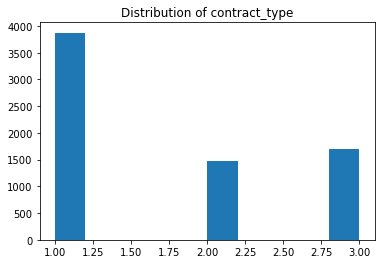

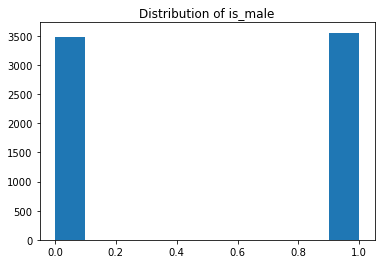

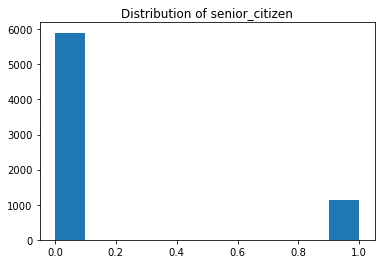

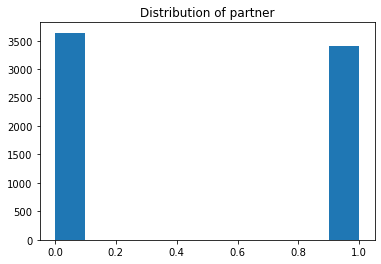

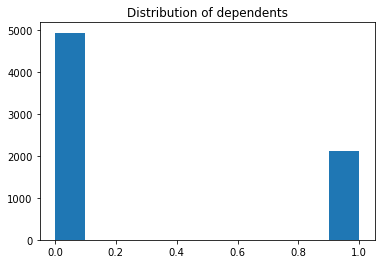

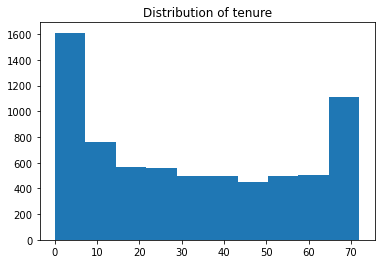

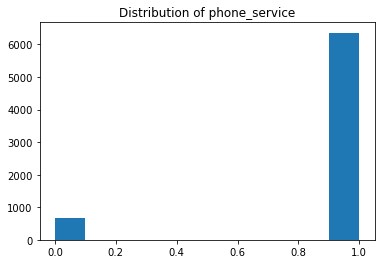

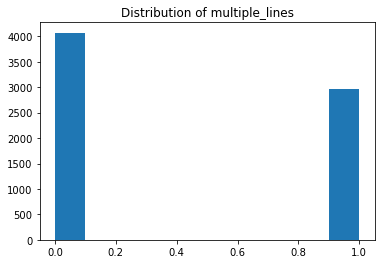

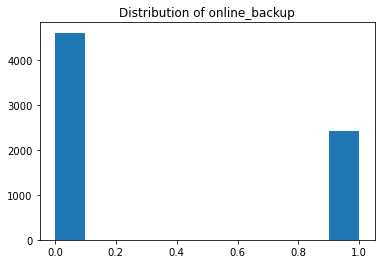

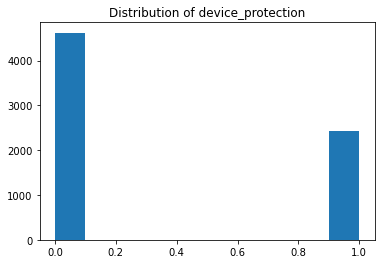

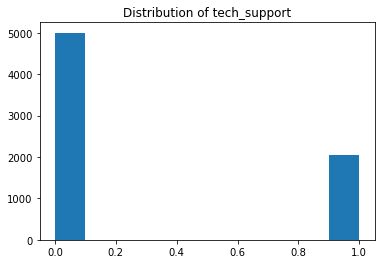

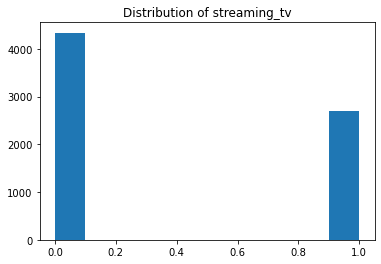

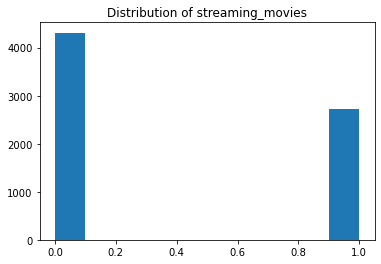

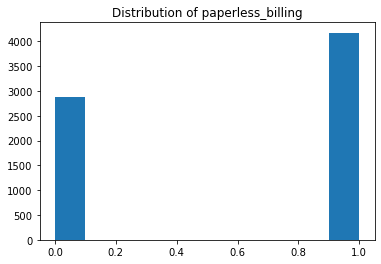

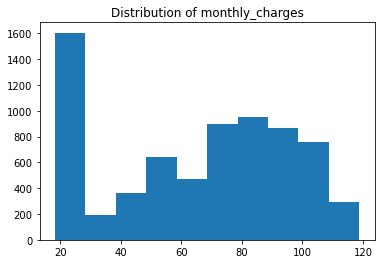

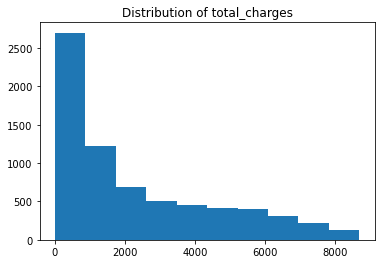

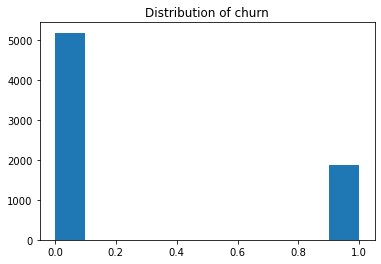

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [10]:
num_distributions(df)

# DSL VS FIBER

In [11]:
df.DSL.value_counts()

0    4622
1    2421
Name: DSL, dtype: int64

In [12]:
df.fiber_optic.value_counts()

0    3947
1    3096
Name: fiber_optic, dtype: int64

In [13]:
df.groupby('fiber_optic').monthly_charges.agg(['min', 'mean', 'max'])

,min,mean,max
fiber_optic,,,
0,18.25,43.788244,94.80
1,67.75,91.500129,118.75


In [14]:
df.groupby('fiber_optic').monthly_charges.agg(['min', 'mean', 'max'])

,min,mean,max
fiber_optic,,,
0,18.25,43.788244,94.80
1,67.75,91.500129,118.75


In [15]:
df.groupby('DSL').monthly_charges.agg(['min', 'mean', 'max'])

,min,mean,max
DSL,,,
0,18.25,68.249946,118.75
1,23.45,58.102169,94.80


In [16]:
churned = df[df['churn'] == 1].tenure


In [17]:
dsl = df[df['DSL'] == 1]

In [18]:
fiber = df[df['fiber_optic'] == 1]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   contract_type      7043 non-null   int64  
 1   is_male            7043 non-null   int64  
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   int64  
 4   dependents         7043 non-null   int64  
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   int64  
 7   multiple_lines     7043 non-null   int64  
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   int64  
 10  device_protection  7043 non-null   int64  
 11  tech_support       7043 non-null   int64  
 12  streaming_tv       7043 non-null   int64  
 13  streaming_movies   7043 non-null   int64  
 14  paperless_billing  7043 non-null   int64  
 15  monthly_charges    7043 non-null   float64
 16  total_charges      7043 

In [19]:
observed = pd.crosstab(mpg.drv, mpg.transmission)
observed

NameError: name 'mpg' is not defined

In [20]:
observed = pd.crosstab(df.DSL, df.churn)
observed

churn,0,1
DSL,,
0,3212,1410
1,1962,459


In [21]:
observed = pd.crosstab(df.fiber_optic, df.churn)
observed

churn,0,1
fiber_optic,,
0,3375,572
1,1799,1297


# Churn

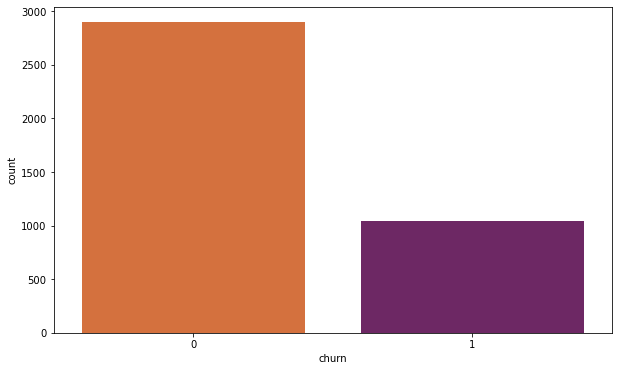

In [73]:
plt.figure(figsize=(10,6))
sns.countplot(x='churn', data=train, palette='inferno_r')
plt.show()

In [77]:
telco_correlation = train.corr['churn']
telco_correlation

,contract_type,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_backup,device_protection,...,churn,payment_type,online_secuirty,payment_type,DSL,fiber_optic,no_internet,month_to_month,one_year_contract,two_year_contract
contract_type,1.000000,0.000909,-0.162383,0.284303,0.250273,0.660485,-0.002429,0.101511,0.153642,0.216590,...,-0.396156,0.329100,0.256118,0.329100,0.064948,-0.254200,0.233006,-0.917134,0.182088,0.887957
is_male,0.000909,1.000000,0.007243,-0.014710,-0.007656,0.004282,-0.009084,-0.006712,-0.026238,-0.007760,...,0.006885,-0.008913,-0.010711,-0.008913,0.003341,-0.006451,0.003944,-0.005867,0.012583,-0.005001
senior_citizen,-0.162383,0.007243,1.000000,0.021704,-0.201859,0.007666,0.017884,0.137272,0.063849,0.054971,...,0.165482,-0.023511,-0.052215,-0.023511,-0.120798,0.273674,-0.191692,0.157663,-0.051119,-0.134109
partner,0.284303,-0.014710,0.021704,1.000000,0.463617,0.366470,0.041129,0.155811,0.135489,0.140242,...,-0.137696,0.149661,0.144792,0.149661,-0.010031,0.005104,0.005469,-0.268490,0.070877,0.243511
dependents,0.250273,-0.007656,-0.201859,0.463617,1.000000,0.160178,0.000945,-0.013628,0.029841,0.013517,...,-0.160315,0.102038,0.093181,0.102038,0.049894,-0.167655,0.145469,-0.236495,0.062744,0.214199
tenure,0.660485,0.004282,0.007666,0.366470,0.160178,1.000000,0.006187,0.325379,0.364211,0.349927,...,-0.352282,0.392603,0.328232,0.392603,0.020264,0.023973,-0.052663,-0.637509,0.198606,0.549839
phone_service,-0.002429,-0.009084,0.017884,0.041129,0.000945,0.006187,1.000000,0.284602,-0.035837,-0.069898,...,0.011995,-0.007627,-0.097775,-0.007627,-0.457254,0.295699,0.172852,0.004231,-0.005385,0.000155
multiple_lines,0.101511,-0.006712,0.137272,0.155811,-0.013628,0.325379,0.284602,1.000000,0.211970,0.201066,...,0.041917,0.116511,0.098892,0.116511,-0.214480,0.382392,-0.214702,-0.086136,0.001305,0.098173
online_backup,0.153642,-0.026238,0.063849,0.135489,0.029841,0.364211,-0.035837,0.211970,1.000000,0.310676,...,-0.079113,0.157486,0.280355,0.157486,0.158861,0.165721,-0.385889,-0.158345,0.070988,0.116309
device_protection,0.216590,-0.007760,0.054971,0.140242,0.013517,0.349927,-0.069898,0.201066,0.310676,1.000000,...,-0.063270,0.167897,0.283492,0.167897,0.154877,0.170772,-0.387386,-0.217549,0.086082,0.170505


ValueError: 'Set4' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [22]:
categ = df.nunique()[df.nunique() <= 5].index
list(categ)

['contract_type',
 'is_male',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract',
 'payment_type',
 'online_secuirty',
 'payment_type',
 'DSL',
 'fiber_optic',
 'no_internet',
 'month_to_month',
 'one_year_contract',
 'two_year_contract']

In [27]:
cat_vars = ['contract_type',
 'is_male',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract',
 'payment_type',
 'online_secuirty',
 'payment_type',
 'DSL',
 'fiber_optic',
 'no_internet',
 'month_to_month',
 'one_year_contract',
 'two_year_contract']

quant_vars = ['total_charges', 'tenure', 'monthly_charges']

In [29]:
df.drop_duplicates()

,contract_type,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,contract,payment_type,online_secuirty,payment_type,DSL,fiber_optic,no_internet,month_to_month,one_year_contract,two_year_contract
0,3,0,0,1,1,65,1,1,Yes,1,...,Two year,0,1,0,1,0,0,0,0,1
1,3,1,0,0,0,54,0,0,Yes,0,...,Two year,1,1,1,1,0,0,0,0,1
2,3,0,0,0,0,56,0,0,Yes,1,...,Two year,1,1,1,1,0,0,0,0,1
3,3,1,0,1,1,20,0,0,Yes,0,...,Two year,1,1,1,1,0,0,0,0,1
4,3,1,0,1,0,72,1,1,No,1,...,Two year,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,1,1,1,1,0,No internet service,0,...,Month-to-month,0,0,0,0,0,1,1,0,0
7039,1,0,0,0,0,19,1,0,No internet service,0,...,Month-to-month,0,0,0,0,0,1,1,0,0
7040,1,0,0,0,0,6,1,0,No internet service,0,...,Month-to-month,1,0,1,0,0,1,1,0,0
7041,1,1,0,0,0,1,1,0,No internet service,0,...,Month-to-month,0,0,0,0,0,1,1,0,0


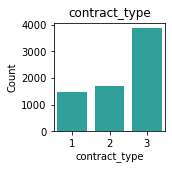

   contract_type  Count  Percent
1              3   3875    55.02
3              2   1695    24.07
2              1   1473    20.91
_________________________________________________________________


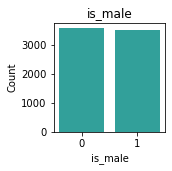

   is_male  Count  Percent
1        0   3555    50.48
0        1   3488    49.52
_________________________________________________________________


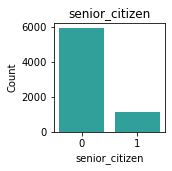

   senior_citizen  Count  Percent
0               0   5901    83.79
1               1   1142    16.21
_________________________________________________________________


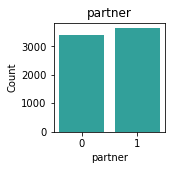

   partner  Count  Percent
0        1   3641     51.7
1        0   3402     48.3
_________________________________________________________________


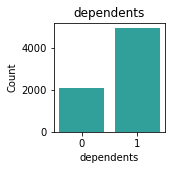

   dependents  Count  Percent
0           1   4933    70.04
1           0   2110    29.96
_________________________________________________________________


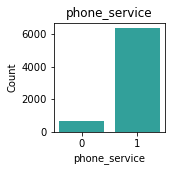

   phone_service  Count  Percent
1              1   6361    90.32
0              0    682     9.68
_________________________________________________________________


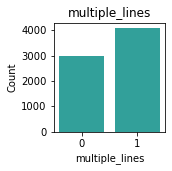

   multiple_lines  Count  Percent
0               1   4072    57.82
1               0   2971    42.18
_________________________________________________________________


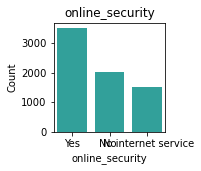

                         online_security  Count  Percent
No                                   Yes   3498    49.67
Yes                                   No   2019    28.67
No internet service  No internet service   1526    21.67
_________________________________________________________________


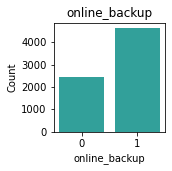

   online_backup  Count  Percent
0              1   4614    65.51
1              0   2429    34.49
_________________________________________________________________


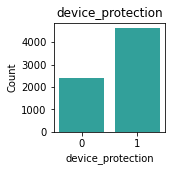

   device_protection  Count  Percent
0                  1   4621    65.61
1                  0   2422    34.39
_________________________________________________________________


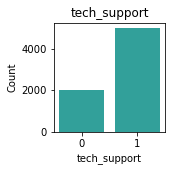

   tech_support  Count  Percent
0             1   4999    70.98
1             0   2044    29.02
_________________________________________________________________


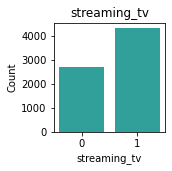

   streaming_tv  Count  Percent
0             1   4336    61.56
1             0   2707    38.44
_________________________________________________________________


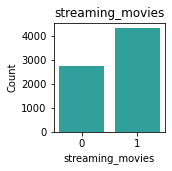

   streaming_movies  Count  Percent
0                 1   4311    61.21
1                 0   2732    38.79
_________________________________________________________________


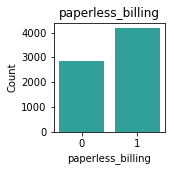

   paperless_billing  Count  Percent
1                  1   4171    59.22
0                  0   2872    40.78
_________________________________________________________________


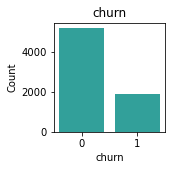

   churn  Count  Percent
0      0   5174    73.46
1      1   1869    26.54
_________________________________________________________________


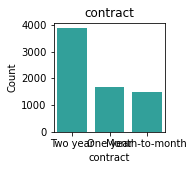

                      contract  Count  Percent
Month-to-month        Two year   3875    55.02
Two year              One year   1695    24.07
One year        Month-to-month   1473    20.91
_________________________________________________________________


AttributeError: 'DataFrame' object has no attribute 'unique'

In [30]:
user_defined_functions.explore_univariate(df, cat_vars, quant_vars)

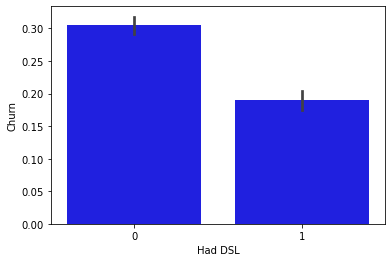

In [34]:
x = sns.barplot(x="DSL", y="churn", data=df, color="blue")
x.set(xlabel="Had DSL", ylabel = "Churn")
plt.show()

In [ ]:
sns.pairplot(df[[ 'DSL', 'fiber_optic', 'churn']], hue='churn')
plt.show()

In [ ]:
sns.pairplot(df[['tenure', 'monthly_charges', 'total_charges', 'churn']], hue='churn')
plt.show()

In [ ]:
#bar plots to show rate of churn within each category
#statistical test - category & category = chi^2
    #if finidng a significant difference then include it in the modeling phase

## Sample questions

### Are customers with DSL more or less likely to churn?
### What month are customers most likely to churn and does that depend on their contract type?
### Is there a service that is associated with more churn than expected?
### Do customers who churn have a higher average monthly spend than those who don't?

In [ ]:
###### PRIMARY FUNCTION!!!!

In [ ]:
# #preliminary clean delco:
# def prep_telco(df):

#     df = df.drop_duplicates()  #Drop duplicates
    
#     #11 values are blank strings for total charges representing 11 customers at 0 tenure
#     df['total_charges'] = df['total_charges'].str.strip() #eliminate white space
#     df['total_charges'] = df['total_charges'].replace('', 0) #replace empty values as 0
#     df['total_charges'] = df['total_charges'].astype('float64')

#     #15 columns encoded to '0' = No, '1'= Yes
#     #contract type MtM = 0, 1year = 1, 2year =2
#     #concated manual billing = 0 , automatic billing = 1
#     df['gender'] = df.gender.replace({'Female': 0, 'Male': 1})
#     df['partner'] = df.partner.replace({'Yes': 1, 'No': 0})
#     df['dependents'] = df.dependents.replace({'Yes': 1, 'No': 0})
#     df['phone_service'] = df.phone_service.replace({'Yes': 1, 'No': 0})
#     df['churn'] = df.churn.replace({'Yes': 1, 'No': 0})
#     df['multiple_lines'] = df.multiple_lines.replace({'No': 0, "Yes": 1, "No phone service": 0})
#     df['online_secuirty'] = df.online_security.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['online_backup'] = df.online_backup.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['device_protection'] = df.device_protection.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['tech_support'] = df.tech_support.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['streaming_tv'] = df.streaming_tv.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['streaming_movies'] = df.streaming_movies.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['paperless_billing'] = df.paperless_billing.replace({'Yes': 1, 'No': 0})
#     #df['contract_type'] = df.contract_type.replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
#     df['payment_type'] = df.payment_type.replace({'Mailed check': 0, 'Credit card (automatic)': 1, 
#                                                'Bank transfer (automatic)': 1,  'Electronic check': 0})


#     # creating dummy values for payment, internet, & contract (*important values*)
#     dummy_df = pd.get_dummies(df[['payment_type',"internet_service_type","contract_type"]])
#     df = pd.concat([df, dummy_df], axis=1)

#     #Rename columns
#     columns_to_rename = {'contract_type': 'contract',
#                     'internet_service_type': 'internet',
#                     'gender': 'is_male',
#                      'payment_type_id': 'payment_id',
#                      'contract_type_id': 'contract_type',
#                      'internet_service_type_DSL': 'DSL',
#                      'internet_service_type_Fiber optic': 'fiber_optic',
#                      'internet_service_type_None': 'no_internet',
#                      'contract_type_Month-to-month': 'month_to_month',
#                      'contract_type_One year': 'one_year_contract',
#                      'contract_type_Two year': 'two_year_contract'}
#     df = df.rename(columns = columns_to_rename)
    
#     #dropping columns not need (#potentially update)
#     columns_to_drop = {'customer_id'}
#     df = df.drop(columns=columns_to_drop)
    
#     return df
    
